In [1]:
import os
import scipy.misc
import numpy as np

from forward_model import DCGAN
from utils import pp, visualize, to_json, show_all_variables

import tensorflow as tf

flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_integer("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", 64, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 108, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", None, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 64, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", None, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "celebA", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("checkpoint_dir", "checkpoint", "Directory name to save the checkpoints [checkpoint]")
flags.DEFINE_string("sample_dir", "samples", "Directory name to save the image samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", True, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
FLAGS = flags.FLAGS

pp.pprint(flags.FLAGS.__flags)

if FLAGS.input_width is None:
    FLAGS.input_width = FLAGS.input_height
if FLAGS.output_width is None:
    FLAGS.output_width = FLAGS.output_height

if not os.path.exists(FLAGS.checkpoint_dir):
    os.makedirs(FLAGS.checkpoint_dir)
if not os.path.exists(FLAGS.sample_dir):
    os.makedirs(FLAGS.sample_dir)

#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth=True

with tf.Session(config=run_config) as sess:
  dcgan = DCGAN(
      sess,
      input_width=FLAGS.input_width,
      input_height=FLAGS.input_height,
      output_width=FLAGS.output_width,
      output_height=FLAGS.output_height,
      batch_size=FLAGS.batch_size,
      sample_num=FLAGS.batch_size,
      dataset_name=FLAGS.dataset,
      input_fname_pattern=FLAGS.input_fname_pattern,
      crop=FLAGS.crop,
      checkpoint_dir=FLAGS.checkpoint_dir,
      sample_dir=FLAGS.sample_dir)

show_all_variables()

if not dcgan.load(FLAGS.checkpoint_dir)[0]:
  raise Exception("[!] Train a model first, then run test mode")
      

#OPTION = 0
#visualize(sess, dcgan, FLAGS, OPTION)


{}
---------
Variables: name (type shape) [size]
---------
generator/g_h0_lin/Matrix:0 (float32_ref 100x8192) [819200, bytes: 3276800]
generator/g_h0_lin/bias:0 (float32_ref 8192) [8192, bytes: 32768]
generator/g_bn0/beta:0 (float32_ref 512) [512, bytes: 2048]
generator/g_bn0/gamma:0 (float32_ref 512) [512, bytes: 2048]
generator/g_h1/w:0 (float32_ref 5x5x256x512) [3276800, bytes: 13107200]
generator/g_h1/biases:0 (float32_ref 256) [256, bytes: 1024]
generator/g_bn1/beta:0 (float32_ref 256) [256, bytes: 1024]
generator/g_bn1/gamma:0 (float32_ref 256) [256, bytes: 1024]
generator/g_h2/w:0 (float32_ref 5x5x128x256) [819200, bytes: 3276800]
generator/g_h2/biases:0 (float32_ref 128) [128, bytes: 512]
generator/g_bn2/beta:0 (float32_ref 128) [128, bytes: 512]
generator/g_bn2/gamma:0 (float32_ref 128) [128, bytes: 512]
generator/g_h3/w:0 (float32_ref 5x5x64x128) [204800, bytes: 819200]
generator/g_h3/biases:0 (float32_ref 64) [64, bytes: 256]
generator/g_bn3/beta:0 (float32_ref 64) [64, byte

In [2]:
from glob import glob
from ops import *
from utils import *

data = glob("./data/celebA/*.jpg")


sample_files = data[0:64] #change to 64 images
sample = [get_image(sample_file, input_height=dcgan.input_height,
                    input_width=dcgan.input_width,
                    resize_height=dcgan.output_height,
                    resize_width=dcgan.output_width,
                    crop=dcgan.crop,
                    grayscale=dcgan.grayscale) for sample_file in sample_files]

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

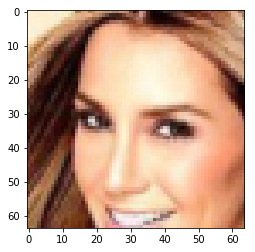

In [4]:
plt.imshow((sample[0] + 1)/2)

In [5]:
v = np.reshape(sample, (64, 64*64*3))
n = v.shape[1]
print(n)

12288


In [6]:
m = 1000
A = np.random.randn(n, m).astype('float32')

In [7]:
y = np.dot(v, A) 

In [21]:

y_placeholder = tf.placeholder(tf.float32,[None,m])

our_loss = tf.reduce_mean( tf.reduce_sum( (tf.matmul(tf.reshape(dcgan.G, [64, -1]) , A) - y_placeholder)**2 ) ) #need to change from vector to matrix for 64 

In [22]:
#z_optim = tf.train.AdamOptimizer(0.0002, 0.5).minimize(our_loss, var_list=dcgan.z)
    
grad = tf.gradients(our_loss, dcgan.z)

z_0 = np.random.uniform(-0.5, 0.5, size=(64 , 100))

prev2 = 9999999999
prev1 = 999999999

rate = 0.01
count = 0

errs = []
    
with tf.Session() as sess:
    try:
      tf.global_variables_initializer().run()
    except:
      tf.initialize_all_variables().run()
    
    while prev1 < prev2 or rate > 0.00000000002: # run until error stops decreasing or reaches threshhold, then print result at that point
        print('iteration {}'.format(count))
        a, closs, b = sess.run([grad, our_loss, dcgan.G],
            feed_dict={ 
              dcgan.z: z_0,
              y_placeholder: y
            })
        count += 1
        prev2, prev1 = prev1, closs
        if count % 100 == 0:
            rate /= 2
        print(closs)
        errs.append(closs)
        z_0 = z_0 - rate*a[0]
    

iteration 0
2.60476e+08
iteration 1
2.51925e+08
iteration 2
2.51873e+08
iteration 3
2.5182e+08
iteration 4
2.51768e+08
iteration 5
2.51716e+08
iteration 6
2.51663e+08
iteration 7
2.51611e+08
iteration 8
2.51559e+08
iteration 9
2.51507e+08
iteration 10
2.51455e+08
iteration 11
2.51403e+08
iteration 12
2.51351e+08
iteration 13
2.51299e+08
iteration 14
2.51248e+08
iteration 15
2.51197e+08
iteration 16
2.51145e+08
iteration 17
2.51093e+08
iteration 18
2.51042e+08
iteration 19
2.50991e+08
iteration 20
2.50941e+08
iteration 21
2.50889e+08
iteration 22
2.50839e+08
iteration 23
2.50787e+08
iteration 24
2.50737e+08
iteration 25
2.50686e+08
iteration 26
2.50635e+08
iteration 27
2.50585e+08
iteration 28
2.50534e+08
iteration 29
2.50484e+08
iteration 30
2.50433e+08
iteration 31
2.50384e+08
iteration 32
2.50333e+08
iteration 33
2.50283e+08
iteration 34
2.50234e+08
iteration 35
2.50184e+08
iteration 36
2.50135e+08
iteration 37
2.50085e+08
iteration 38
2.50036e+08
iteration 39
2.49987e+08
iteration 4

2.44081e+08
iteration 322
2.44076e+08
iteration 323
2.44072e+08
iteration 324
2.44067e+08
iteration 325
2.44063e+08
iteration 326
2.44058e+08
iteration 327
2.44053e+08
iteration 328
2.44049e+08
iteration 329
2.44044e+08
iteration 330
2.44039e+08
iteration 331
2.44035e+08
iteration 332
2.4403e+08
iteration 333
2.44026e+08
iteration 334
2.44021e+08
iteration 335
2.44016e+08
iteration 336
2.44012e+08
iteration 337
2.44007e+08
iteration 338
2.44002e+08
iteration 339
2.43998e+08
iteration 340
2.43993e+08
iteration 341
2.43989e+08
iteration 342
2.43984e+08
iteration 343
2.4398e+08
iteration 344
2.43975e+08
iteration 345
2.43971e+08
iteration 346
2.43966e+08
iteration 347
2.43961e+08
iteration 348
2.43956e+08
iteration 349
2.43952e+08
iteration 350
2.43948e+08
iteration 351
2.43943e+08
iteration 352
2.43938e+08
iteration 353
2.43934e+08
iteration 354
2.43929e+08
iteration 355
2.43924e+08
iteration 356
2.4392e+08
iteration 357
2.43915e+08
iteration 358
2.43911e+08
iteration 359
2.43906e+08
ite

2.43367e+08
iteration 639
2.43366e+08
iteration 640
2.43366e+08
iteration 641
2.43365e+08
iteration 642
2.43364e+08
iteration 643
2.43364e+08
iteration 644
2.43363e+08
iteration 645
2.43363e+08
iteration 646
2.43362e+08
iteration 647
2.43362e+08
iteration 648
2.43361e+08
iteration 649
2.4336e+08
iteration 650
2.4336e+08
iteration 651
2.43359e+08
iteration 652
2.43359e+08
iteration 653
2.43358e+08
iteration 654
2.43358e+08
iteration 655
2.43357e+08
iteration 656
2.43357e+08
iteration 657
2.43356e+08
iteration 658
2.43356e+08
iteration 659
2.43355e+08
iteration 660
2.43354e+08
iteration 661
2.43354e+08
iteration 662
2.43353e+08
iteration 663
2.43353e+08
iteration 664
2.43352e+08
iteration 665
2.43352e+08
iteration 666
2.43351e+08
iteration 667
2.43351e+08
iteration 668
2.4335e+08
iteration 669
2.4335e+08
iteration 670
2.43349e+08
iteration 671
2.43348e+08
iteration 672
2.43348e+08
iteration 673
2.43347e+08
iteration 674
2.43347e+08
iteration 675
2.43346e+08
iteration 676
2.43346e+08
iter

2.43288e+08
iteration 956
2.43288e+08
iteration 957
2.43288e+08
iteration 958
2.43288e+08
iteration 959
2.43288e+08
iteration 960
2.43288e+08
iteration 961
2.43288e+08
iteration 962
2.43288e+08
iteration 963
2.43287e+08
iteration 964
2.43287e+08
iteration 965
2.43287e+08
iteration 966
2.43287e+08
iteration 967
2.43287e+08
iteration 968
2.43287e+08
iteration 969
2.43287e+08
iteration 970
2.43287e+08
iteration 971
2.43287e+08
iteration 972
2.43287e+08
iteration 973
2.43287e+08
iteration 974
2.43287e+08
iteration 975
2.43287e+08
iteration 976
2.43287e+08
iteration 977
2.43286e+08
iteration 978
2.43286e+08
iteration 979
2.43286e+08
iteration 980
2.43286e+08
iteration 981
2.43286e+08
iteration 982
2.43286e+08
iteration 983
2.43286e+08
iteration 984
2.43286e+08
iteration 985
2.43286e+08
iteration 986
2.43286e+08
iteration 987
2.43286e+08
iteration 988
2.43286e+08
iteration 989
2.43286e+08
iteration 990
2.43286e+08
iteration 991
2.43286e+08
iteration 992
2.43285e+08
iteration 993
2.43285e+08


2.43279e+08
iteration 1265
2.43279e+08
iteration 1266
2.43279e+08
iteration 1267
2.43279e+08
iteration 1268
2.43279e+08
iteration 1269
2.43279e+08
iteration 1270
2.43279e+08
iteration 1271
2.43279e+08
iteration 1272
2.43279e+08
iteration 1273
2.43279e+08
iteration 1274
2.43279e+08
iteration 1275
2.43279e+08
iteration 1276
2.43279e+08
iteration 1277
2.43279e+08
iteration 1278
2.43279e+08
iteration 1279
2.43279e+08
iteration 1280
2.43279e+08
iteration 1281
2.43279e+08
iteration 1282
2.43279e+08
iteration 1283
2.43279e+08
iteration 1284
2.43279e+08
iteration 1285
2.43279e+08
iteration 1286
2.43279e+08
iteration 1287
2.43279e+08
iteration 1288
2.43279e+08
iteration 1289
2.43279e+08
iteration 1290
2.43279e+08
iteration 1291
2.43279e+08
iteration 1292
2.43279e+08
iteration 1293
2.43279e+08
iteration 1294
2.43279e+08
iteration 1295
2.43279e+08
iteration 1296
2.43279e+08
iteration 1297
2.43279e+08
iteration 1298
2.43279e+08
iteration 1299
2.43279e+08
iteration 1300
2.43279e+08
iteration 1301
2

2.43278e+08
iteration 1569
2.43278e+08
iteration 1570
2.43278e+08
iteration 1571
2.43278e+08
iteration 1572
2.43278e+08
iteration 1573
2.43278e+08
iteration 1574
2.43278e+08
iteration 1575
2.43278e+08
iteration 1576
2.43278e+08
iteration 1577
2.43278e+08
iteration 1578
2.43278e+08
iteration 1579
2.43278e+08
iteration 1580
2.43278e+08
iteration 1581
2.43278e+08
iteration 1582
2.43278e+08
iteration 1583
2.43278e+08
iteration 1584
2.43278e+08
iteration 1585
2.43278e+08
iteration 1586
2.43278e+08
iteration 1587
2.43278e+08
iteration 1588
2.43278e+08
iteration 1589
2.43278e+08
iteration 1590
2.43278e+08
iteration 1591
2.43278e+08
iteration 1592
2.43278e+08
iteration 1593
2.43278e+08
iteration 1594
2.43278e+08
iteration 1595
2.43278e+08
iteration 1596
2.43278e+08
iteration 1597
2.43278e+08
iteration 1598
2.43278e+08
iteration 1599
2.43278e+08
iteration 1600
2.43278e+08
iteration 1601
2.43278e+08
iteration 1602
2.43278e+08
iteration 1603
2.43278e+08
iteration 1604
2.43278e+08
iteration 1605
2

2.43278e+08
iteration 1873
2.43278e+08
iteration 1874
2.43278e+08
iteration 1875
2.43278e+08
iteration 1876
2.43278e+08
iteration 1877
2.43278e+08
iteration 1878
2.43278e+08
iteration 1879
2.43278e+08
iteration 1880
2.43278e+08
iteration 1881
2.43278e+08
iteration 1882
2.43278e+08
iteration 1883
2.43278e+08
iteration 1884
2.43278e+08
iteration 1885
2.43278e+08
iteration 1886
2.43278e+08
iteration 1887
2.43278e+08
iteration 1888
2.43278e+08
iteration 1889
2.43278e+08
iteration 1890
2.43278e+08
iteration 1891
2.43278e+08
iteration 1892
2.43278e+08
iteration 1893
2.43278e+08
iteration 1894
2.43278e+08
iteration 1895
2.43278e+08
iteration 1896
2.43278e+08
iteration 1897
2.43278e+08
iteration 1898
2.43278e+08
iteration 1899
2.43278e+08
iteration 1900
2.43278e+08
iteration 1901
2.43278e+08
iteration 1902
2.43278e+08
iteration 1903
2.43278e+08
iteration 1904
2.43278e+08
iteration 1905
2.43278e+08
iteration 1906
2.43278e+08
iteration 1907
2.43278e+08
iteration 1908
2.43278e+08
iteration 1909
2

2.43278e+08
iteration 2177
2.43278e+08
iteration 2178
2.43278e+08
iteration 2179
2.43278e+08
iteration 2180
2.43278e+08
iteration 2181
2.43278e+08
iteration 2182
2.43278e+08
iteration 2183
2.43278e+08
iteration 2184
2.43278e+08
iteration 2185
2.43278e+08
iteration 2186
2.43278e+08
iteration 2187
2.43278e+08
iteration 2188
2.43278e+08
iteration 2189
2.43278e+08
iteration 2190
2.43278e+08
iteration 2191
2.43278e+08
iteration 2192
2.43278e+08
iteration 2193
2.43278e+08
iteration 2194
2.43278e+08
iteration 2195
2.43278e+08
iteration 2196
2.43278e+08
iteration 2197
2.43278e+08
iteration 2198
2.43278e+08
iteration 2199
2.43278e+08
iteration 2200
2.43278e+08
iteration 2201
2.43278e+08
iteration 2202
2.43278e+08
iteration 2203
2.43278e+08
iteration 2204
2.43278e+08
iteration 2205
2.43278e+08
iteration 2206
2.43278e+08
iteration 2207
2.43278e+08
iteration 2208
2.43278e+08
iteration 2209
2.43278e+08
iteration 2210
2.43278e+08
iteration 2211
2.43278e+08
iteration 2212
2.43278e+08
iteration 2213
2

2.43278e+08
iteration 2481
2.43278e+08
iteration 2482
2.43278e+08
iteration 2483
2.43278e+08
iteration 2484
2.43278e+08
iteration 2485
2.43278e+08
iteration 2486
2.43278e+08
iteration 2487
2.43278e+08
iteration 2488
2.43278e+08
iteration 2489
2.43278e+08
iteration 2490
2.43278e+08
iteration 2491
2.43278e+08
iteration 2492
2.43278e+08
iteration 2493
2.43278e+08
iteration 2494
2.43278e+08
iteration 2495
2.43278e+08
iteration 2496
2.43278e+08
iteration 2497
2.43278e+08
iteration 2498
2.43278e+08
iteration 2499
2.43278e+08
iteration 2500
2.43278e+08
iteration 2501
2.43278e+08
iteration 2502
2.43278e+08
iteration 2503
2.43278e+08
iteration 2504
2.43278e+08
iteration 2505
2.43278e+08
iteration 2506
2.43278e+08
iteration 2507
2.43278e+08
iteration 2508
2.43278e+08
iteration 2509
2.43278e+08
iteration 2510
2.43278e+08
iteration 2511
2.43278e+08
iteration 2512
2.43278e+08
iteration 2513
2.43278e+08
iteration 2514
2.43278e+08
iteration 2515
2.43278e+08
iteration 2516
2.43278e+08
iteration 2517
2

2.43278e+08
iteration 2785
2.43278e+08
iteration 2786
2.43278e+08
iteration 2787
2.43278e+08
iteration 2788
2.43278e+08
iteration 2789
2.43278e+08
iteration 2790
2.43278e+08
iteration 2791
2.43278e+08
iteration 2792
2.43278e+08
iteration 2793
2.43278e+08
iteration 2794
2.43278e+08
iteration 2795
2.43278e+08
iteration 2796
2.43278e+08
iteration 2797
2.43278e+08
iteration 2798
2.43278e+08
iteration 2799
2.43278e+08
iteration 2800
2.43278e+08
iteration 2801
2.43278e+08
iteration 2802
2.43278e+08
iteration 2803
2.43278e+08
iteration 2804
2.43278e+08
iteration 2805
2.43278e+08
iteration 2806
2.43278e+08
iteration 2807
2.43278e+08
iteration 2808
2.43278e+08
iteration 2809
2.43278e+08
iteration 2810
2.43278e+08
iteration 2811
2.43278e+08
iteration 2812
2.43278e+08
iteration 2813
2.43278e+08
iteration 2814
2.43278e+08
iteration 2815
2.43278e+08
iteration 2816
2.43278e+08
iteration 2817
2.43278e+08
iteration 2818
2.43278e+08
iteration 2819
2.43278e+08
iteration 2820
2.43278e+08
iteration 2821
2

[ -0.69134367  26.81949997 -37.75787735  54.44133377   4.692379
 -14.69410706  36.22187424   1.42983937  20.74728394 -10.92124939
 -30.08892822 -20.1027317  -26.28220558  38.35992432 -14.14373493
 -37.18543625 -62.54073715  -5.79386377 -17.72220993 -19.49414062
   1.9192493  -61.53151703  14.35795212 -30.79290199  -6.62881899
  55.34306717  26.65485001 -20.13112259   2.98673916  56.3990097
  24.13974762  23.25629807  19.65059853 -19.11245918 -37.04962921
  26.30412865  -8.64348507   2.05120349 -44.06399536 -12.39945698
  22.07832146  28.11713219  36.07078934 -49.06017303  16.56045723
 -50.91870499 -18.62328148   9.40165424 -59.77835083  55.90052795
  54.35921478  19.17586708  12.83691597  11.66558075  43.26403809
 -76.34351349   4.43213749 -69.83421326 -33.79169464  35.68085861
  22.70601273 -18.27335548  20.0072422   19.58309937 -28.46493912
  15.82243347   4.56167555   1.39087081  17.44076157  -8.83957291
  73.69871521 -40.48232651  64.65080261  12.81115246 -55.1334343
 -17.25830269 

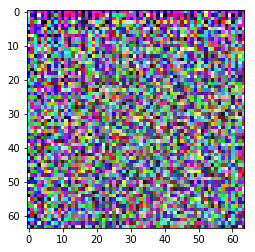

In [24]:
print(a[0][0])
print(a[0].shape)
plt.imshow(b[0])

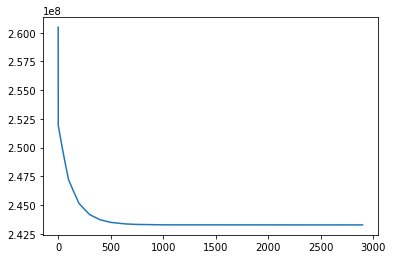

In [25]:
plt.plot(errs)
plt.show()